# Strojno učenje - PMF

Akademska godina 2018./2019.
[https://web.math.pmf.unizg.hr/nastava/su/](https://web.math.pmf.unizg.hr/nastava/su/)

Matija Piškorec

kernel: Python 3.7

# 2. Nadzirano učenje

Nadzirano učenje (engl. supervised learning) tijekom učenja uzima u obzir ciljnu (engl. target) značajku. U sklopu ove vježbe obradit ćemo nekoliko modela nadziranog učenja. Za više informacija pogledajte scikit-learn [korisnički dokumentaciju](http://scikit-learn.org/stable/user_guide.html), prije svega poglavlja:
* [1.1.1. Ordinary Least Squares](http://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) 
* [1.1.2. Ridge Regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression)
* [1.1.3. Lasso](http://scikit-learn.org/stable/modules/linear_model.html#lasso)
* [1.1.16. Polynomial regression: extending linear models with basis functions](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)
* [1.9. Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html)
* [1.4. Support Vector Machines](http://scikit-learn.org/stable/modules/svm.html)
* [1.11.2. Forests of randomized trees](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)

Preduvjeti
-------------

U vježbi ćemo koristiti sljedeće osnovne Python module: [Numpy](http://www.numpy.org/), [Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) i [scikit-learn](http://scikit-learn.org/stable/) (kojeg ćemo učitavati po potrebi).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # version 3.0.2
import numpy as np # version 1.16.0
import pandas as pd # version 0.24.1
import scipy # version 1.2.1

Koristit ćemo pomoćnu funkciju `calculate_decision_function()` za evaluaciju klasifikatora na 2-dimenzionalnom gridu točaka, što će nam pomoći u vizualizaciji decizijske ravnine kasnije.

In [2]:
def calculate_decision_function(X,model):
    '''
    Create a 2D grid to evaluate model.
    '''

    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = model(xy).reshape(XX.shape)

    return (XX,YY,Z)

Koristit ćemo dva stvarna dataseta dostupna unutar scikit-learna: [`diabetes`](http://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) dataset koji se sastoji od 442 primjera i 10 atributa, te ciljnu varijablu kao realni broj, i [`20newsgroups`](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups) dataset koji se sastoji od 18000 tekstova podjeljenih u 20 kategorija, a koji je zbog veličine dostupan i lokalno u repozitoriju ovih vježbi.

Za ostale datasetove dostupne unutar scikit-learna pogledajte službenu dokumentaciju na [`sklearn.datasets`](http://scikit-learn.org/dev/modules/classes.html#module-sklearn.datasets).

# 2.1. Linearna regesija

Linearna regresija pretpostavlja da je ciljna značajka $y$ linearna kombinacija ulaznih značajki $X = \{x_1,\dots,x_p\}$:

$$
\hat{y}(w,x) = w_0 + w_1 x_1 + \dots + w_p x_p
$$

Pri čemu su parametri našeg linearnog modela $w=(w_0,\dots,w_p)$ koji se mogu naći ("naučiti") pomoću metode najmanjih kvadrata (engl. least squares). Optimizacijski problem je sljedeći:

$$
\underset{w}{min\,} {{\| X w - y \|_2}^2}
$$

Za linearnu regresiju ćemo koristiti funkciju [`sklearn.linear_model.LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) koja koristi implementaciju najmanjih kvadrata iz [`scipy.linalg.lstsq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html). Za sličan primjer iz službene dokumentacije pogledajte [Linear Regression Example](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py). Zbog ilustracije koristit ćemo umjetni regresijski skup podataka kojeg generira funkcija [`sklearn.datasets.make_regression`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html).

In [3]:
from sklearn import datasets # version 0.20.2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # u starijim verzijama sklearna nalazi se u modulu cross_validation
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import matplotlib.mlab as mlab

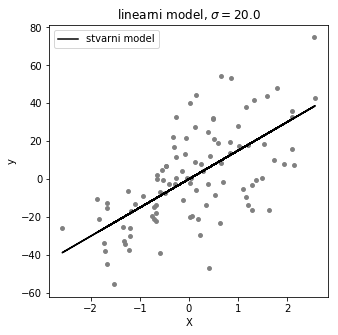

In [4]:
X, y, coef = make_regression(n_samples=100, n_features=1, noise=20.0, coef=True, random_state=38)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(X, y, c='gray', s=15) #, s=10, cmap=plt.cm.Set1)
ax.plot(X,np.dot(coef,X), '-', color='black', label='stvarni model')
ax.legend(loc='upper left')
ax.set(xlabel='X',ylabel='y',title='linearni model, $\sigma=20.0$')

plt.show();

U praksi nas uvijek zanima kako naš naučeni model predviđa još neviđene podatke. Kako ovdje radimo s umjetno generiranim podacima, testne podatke ćemo simulirati tako što ćemo odvojiti $40\%$ podataka za testiranje. Ovaj postupak ćemo ponoviti i  vizualizirat ćemo tako dobivene modele.

Za evaluaciju možemo koristiti neku od regresijskih mjera implementiranih u sciki-learnu (pogledajte [Regression metrics](http://scikit-learn.org/stable/modules/classes.html#regression-metrics)), primjerice objašnjenu varijancu implementiranu u funkciji [`sklearn.metrics.explained_variance_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html) ili $R^2$ statistiku (kvadrat Pearsonovog koeficijenta korelacije između stvarne vrijednosti $y$ i predviđene vrijednosti $\hat{y}$) implementiranu u funkciji [`sklearn.metrics.r2_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score), koja je također i defaultna metrika za [`sklearn.linear_model.LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression).

Metoda najmanjih kvadrata daje Bayes-optimalno rješenje pod pretpostavkom da je stvarni model zaista linearan i da je šum u ciljnoj značajki $y$ normalno raspodijeljen. Ovu pretpostavku moguće je vizualno provjeriti plotanjem reziduala - odstupanja od predviđene vrijednosti $\hat{y}$ za svaki od ulaznih primjera.

Objasnjena varijanca: 0.47


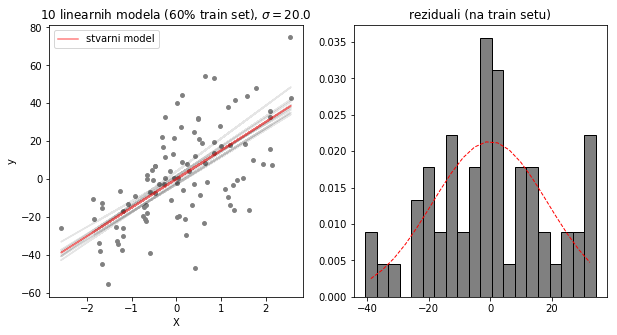

In [5]:
X, y, coef = make_regression(n_samples=100, n_features=1, noise=20.0, coef=True, random_state=38)
# X, y, coef = make_regression(n_samples=3000, n_features=1, noise=20.0, coef=True, random_state=38)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X, y, c='gray', s=15)

for temp in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) # , random_state=42)

    model = Pipeline([('linear', LinearRegression())])
    model.fit(X_train, y_train)
    
    ax[0].plot(X_train,model.predict(X_train), '-', color='black', alpha=0.1) #, label='linearni model')

ax[0].plot(X,np.dot(coef,X), '-', color='red', alpha=0.5, label='stvarni model')
ax[0].set(xlabel='X',ylabel='y',title='10 linearnih modela (60% train set), $\sigma=20.0$')
ax[0].legend(loc='upper left')

# Residuals
residuals = model.predict(X_train)-y_train
n, bins, patches = ax[1].hist(residuals,bins=20,density=True,color='gray',edgecolor='black')

bincenters = 0.5*(bins[1:]+bins[:-1])
y_norm = scipy.stats.norm.pdf( bincenters, np.mean(residuals), np.std(residuals))
l = ax[1].plot(bincenters, y_norm, 'r--', linewidth=1, label='gaussian')

ax[1].set(title='reziduali (na train setu)')

print('Objasnjena varijanca: ' + '{0:.2f}'.format(explained_variance_score(y_train,model.predict(X_train))))

plt.show();

**Vježba 2.1.** Unesite kvadratnu ovisnost u podatke i provjerite kako se to odražava na objašnjenu varijancu i reziduale.

Objasnjena varijanca: 0.40


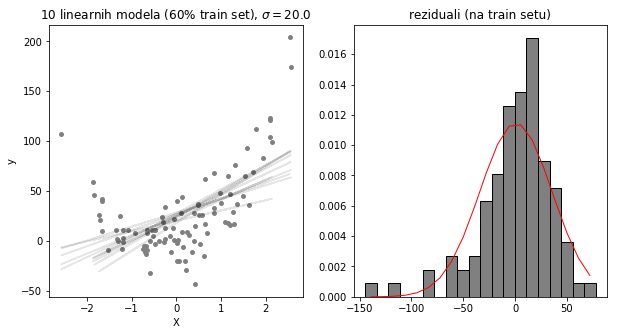

In [6]:
X, y, coef = make_regression(n_samples=100, n_features=1, noise=20.0, coef=True, random_state=38)
# X, y, coef = make_regression(n_samples=3000, n_features=1, noise=20.0, coef=True, random_state=38)

# Dodavanje kvadratnog trenda
y = y[:,np.newaxis] + 20.0 * X**2

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].scatter(X, y, c='gray', s=15)

for temp in range(10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) # , random_state=42)

    model = Pipeline([('linear', LinearRegression())])
    model.fit(X_train, y_train)
    
    ax[0].plot(X_train,model.predict(X_train), '-', color='black', alpha=0.1) #, label='linearni model')

ax[0].set(xlabel='X',ylabel='y',title='10 linearnih modela (60% train set), $\sigma=20.0$')

# Residuals
residuals = model.predict(X)-y
n, bins, patches = ax[1].hist(residuals,bins=20,density=True,color='gray',edgecolor='black')

bincenters = 0.5*(bins[1:]+bins[:-1])
y_norm = scipy.stats.norm.pdf( bincenters, np.mean(residuals), np.std(residuals))
l = ax[1].plot(bincenters, y_norm, 'r-', linewidth=1, label='gaussian')

ax[1].set(title='reziduali (na train setu)')

print('Objasnjena varijanca: ' + '{0:.2f}'.format(explained_variance_score(y_train,model.predict(X_train))))

plt.show();

**Primjer sa stvarnim podacima:** Diabetes dataset.

In [7]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
diabetes = pd.DataFrame(data=np.c_[diabetes['data'], diabetes['target']], 
                             columns=np.append(['X'+str(i) for i in range(len(diabetes['data'][0]))],'target'))
diabetes.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0


In [8]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
X0        442 non-null float64
X1        442 non-null float64
X2        442 non-null float64
X3        442 non-null float64
X4        442 non-null float64
X5        442 non-null float64
X6        442 non-null float64
X7        442 non-null float64
X8        442 non-null float64
X9        442 non-null float64
target    442 non-null float64
dtypes: float64(11)
memory usage: 38.1 KB


Zbog lakše vizualizacije odabrat ćemo samo jednu značajku s kojom ćemo učiti naš linearni model. Metode za odabir značajki radit ćemo u jednoj od sljedećih vježbi, a sada ćemo jednostavno odabrati onu značajku koja daje najveću korelaciju s ciljnom značajkom.

In [9]:
diabetes.drop('target',axis=1).corrwith(diabetes['target']) # Korelacija s ciljnim znacajkom

X0    0.187889
X1    0.043062
X2    0.586450
X3    0.441484
X4    0.212022
X5    0.174054
X6   -0.394789
X7    0.430453
X8    0.565883
X9    0.382483
dtype: float64

Objasnjena varijanca: 0.37


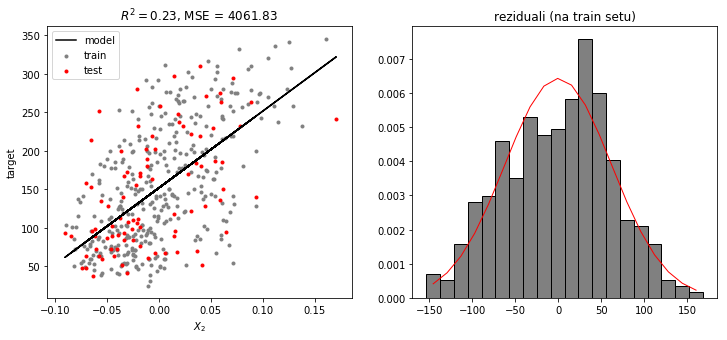

In [10]:
# Koristenje samo jedne znacajke X2
diabetes_train, diabetes_test = train_test_split(diabetes[['X2','target']], test_size=0.20, random_state=42)

model = Pipeline([('linear', LinearRegression())])
model = model.fit(diabetes_train.drop('target',axis=1),diabetes_train['target'])

diabetes_target_pred = model.predict(diabetes_test.drop('target',axis=1))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(diabetes_train.drop('target',axis=1).values, diabetes_train['target'], color='gray', marker='.', label='train')
ax[0].scatter(diabetes_test.drop('target',axis=1).values, diabetes_test['target'], color='red', marker='.', label='test')

ax[0].plot(diabetes_test.drop('target',axis=1).values, diabetes_target_pred, color='black', label='model')

R2 = r2_score(diabetes_test['target'], diabetes_target_pred) # Objasnjena varijanca
# R2 = model.score(diabetes_test.drop('target',axis=1),diabetes_test['target']) # Ekvivalentno za LinearRegression()

MSE = mean_squared_error(diabetes_test['target'], diabetes_target_pred) # Srednja kvadratna pogreska

ax[0].set(title='$R^2 = $'+'{0:.2f}'.format(R2)+', MSE = '+'{0:.2f}'.format(MSE))
ax[0].set(xlabel='$X_2$',ylabel='target')
ax[0].legend(loc='upper left')


# Reziduali
residuals = model.predict(diabetes_train.drop('target',axis=1))-diabetes_train['target']
n, bins, patches = ax[1].hist(residuals,bins=20,density=True,color='gray',edgecolor='black')

bincenters = 0.5*(bins[1:]+bins[:-1])
y_norm = scipy.stats.norm.pdf( bincenters, np.mean(residuals), np.std(residuals))
l = ax[1].plot(bincenters, y_norm, 'r-', linewidth=1, label='gaussian')

ax[1].set(title='reziduali (na train setu)')

explained_variance = explained_variance_score(diabetes_train['target'],model.predict(diabetes_train.drop('target',axis=1)))
print('Objasnjena varijanca: ' + '{0:.2f}'.format(explained_variance))

plt.show();

In [11]:
# Koeficijent linearne regresije
print(model.named_steps['linear'].coef_)

[998.57768914]


**Pitanje 2.1.** Koja je interpretacija ovog koeficijenta linearne regresije?

**Vježba 2.2.** Ponovite linearnu regresiju ali ovaj put koristeći *sve* atribute. Kako se promijenila objašnjena varijanca $R^2$?

In [12]:
diabetes_train, diabetes_test = train_test_split(diabetes, test_size=0.20, random_state=42)

model = Pipeline([('linear', LinearRegression())])
model = model.fit(diabetes_train.drop('target',axis=1),diabetes_train['target'])

diabetes_target_pred = model.predict(diabetes_test.drop('target',axis=1))

R2 = r2_score(diabetes_test['target'], diabetes_target_pred) # Objasnjena varijanca
MSE = mean_squared_error(diabetes_test['target'], diabetes_target_pred) # Srednja kvadratna pogreska

print('R2 = '+'{0:.2f}'.format(R2)+', MSE = '+'{0:.2f}'.format(MSE))

R2 = 0.45, MSE = 2900.17


Objasnjena varijanca: 0.53


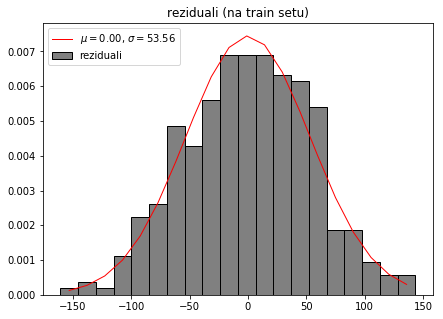

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

residuals = model.predict(diabetes_train.drop('target',axis=1))-diabetes_train['target']
n, bins, patches = ax.hist(residuals, bins=20, density=True, color='gray', edgecolor='black', label='reziduali')

bincenters = 0.5*(bins[1:]+bins[:-1])
residuals_mu = np.mean(residuals)
residuals_std = np.std(residuals)
y_norm = scipy.stats.norm.pdf( bincenters, residuals_mu, residuals_std )
l = ax.plot(bincenters, y_norm, 'r-', linewidth=1, 
            label='$\mu='+'{0:.2f}'.format(residuals_mu)+'$, $\sigma='+'{0:.2f}'.format(residuals_std)+'$')

ax.set(title='reziduali (na train setu)')
ax.legend(loc='upper left')

explained_variance = explained_variance_score(diabetes_train['target'],model.predict(diabetes_train.drop('target',axis=1)))
print('Objasnjena varijanca: ' + '{0:.2f}'.format(explained_variance))

plt.show();

In [14]:
# Koeficijenti linearne regresije za svaki atribut
for i in zip(diabetes.drop('target',axis=1).columns,model.named_steps['linear'].coef_):
    print(i)

('X0', 37.900314258246176)
('X1', -241.96624835284481)
('X2', 542.4257534189245)
('X3', 347.7083052922805)
('X4', -931.4612609313975)
('X5', 518.0440554737877)
('X6', 163.40353476472748)
('X7', 275.3100383668223)
('X8', 736.1890983908113)
('X9', 48.6711248828014)


**Pitanje 2.2.** Kako se promjenio koeficijent linearne regresije za atribut $X_2$ i zašto? Koja je korespondencija između koeficijenata linearne regresije i korelacije s ciljnim atributom koju smo izračunali ranije?

# 2.2. Regularizacija u linearnoj regresiji

Regularizacija je proces ograničavanja kompleksnosti modela kako bi se postigla bolja prediktivna moć na još neviđenim primjerima. U slučaju linearne regresije jedan od načina za kontrolirati kompleksnost modela je pomoću norme vektora koeficijenata $w=(w_0,\dots,w_p)$. Za normu se recimo može odabrati $l_1$, $l_2$ ili kombinacija njih dvije, pri čemu su optimizaicjski problemi sljedeći:

* $l_1$-norma: $\underset{w}{min\,} { \frac{1}{2N} \|X w - y\|_2 ^ 2 + \alpha \|w\|_1}$ (Lasso regresija)
 
* $l_2$-norma: $\underset{w}{min\,} {{\| X w - y\|_2}^2 + \alpha {\|w\|_2}^2}$ (Ridge regresija)

* Kombinacija $l_1$ i $l_2$-norme: $\underset{w}{min\,} { \frac{1}{2n_{samples}} \|X w - y\|_2 ^ 2 + \alpha \rho \|w\|_1 +
\frac{\alpha(1-\rho)}{2} \|w\|_2 ^ 2}$ (Elastic net regresija)

Gdje je $\alpha \geq 0$ regularizacijski parameter koji određuje jačinu regularizacije, a $\rho$ udio $l_1$ norme u regularizaciji. Lasse regresija je implementirana u funkciji [`sklearn.linear_model.Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), Ridge regresija u [`sklearn.linear_model.Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) a Elastic net regersija u [`sklearn.linear_model.ElasticNet`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet). Prednost $l_1$-norme kao regularizacijskog kriterija je što vodi do rijetkih (engl. sparse) modela - smanjuje koeficijente točno na nulu.

In [15]:
from sklearn import datasets
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split # u starijim verzijama sklearna nalazi se u modulu cross_validation
from sklearn.pipeline import Pipeline

In [16]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()
diabetes = pd.DataFrame(data=np.c_[diabetes['data'], diabetes['target']], 
                             columns=np.append(['X'+str(i) for i in range(len(diabetes['data'][0]))],'target'))

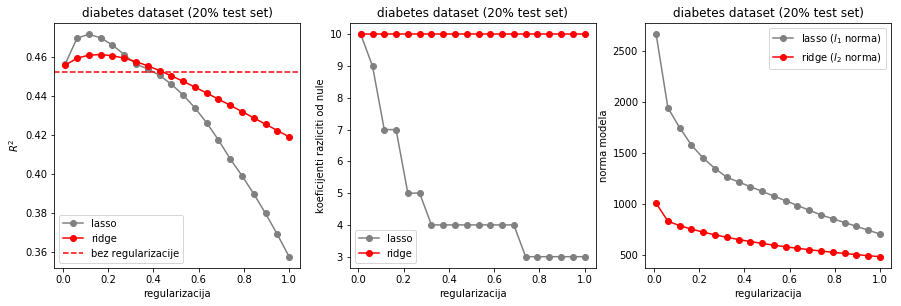

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

alpha_array = np.linspace(0.01,1.0,20)
R2_lasso = []
R2_ridge = []
n_coef_lasso = []
n_coef_ridge = []
norm_lasso = []
norm_ridge = []
norm_lasso1 = []
norm_ridge1 = []

for alpha in alpha_array:
    
    diabetes_train, diabetes_test = train_test_split(diabetes, test_size=0.20, random_state=42)

    model_lasso = Pipeline([('lasso', Lasso(alpha=alpha))])
    model_ridge = Pipeline([('ridge', Ridge(alpha=alpha))])
    
    model_lasso = model_lasso.fit(diabetes_train.drop('target',axis=1),diabetes_train['target'])
    model_ridge = model_ridge.fit(diabetes_train.drop('target',axis=1),diabetes_train['target'])

    R2_lasso.append(model_lasso.score(diabetes_test.drop('target',axis=1),diabetes_test['target']))
    R2_ridge.append(model_ridge.score(diabetes_test.drop('target',axis=1),diabetes_test['target']))
    
    n_coef_lasso.append(np.count_nonzero(model_lasso.named_steps['lasso'].coef_))
    n_coef_ridge.append(np.count_nonzero(model_ridge.named_steps['ridge'].coef_))
    
    norm_lasso.append(np.linalg.norm(model_lasso.named_steps['lasso'].coef_,ord=1))
    norm_ridge.append(np.linalg.norm(model_ridge.named_steps['ridge'].coef_,ord=2))
    
ax[0].plot(alpha_array, R2_lasso, '-o', color='gray', label='lasso') 
ax[0].plot(alpha_array, R2_ridge, '-o', color='red', label='ridge') 
ax[1].plot(alpha_array, n_coef_lasso, '-o', color='gray', label='lasso') 
ax[1].plot(alpha_array, n_coef_ridge, '-o', color='red', label='ridge') 
ax[2].plot(alpha_array, norm_lasso, '-o', color='gray', label='lasso ($l_1$ norma)') 
ax[2].plot(alpha_array, norm_ridge, '-o', color='red', label='ridge ($l_2$ norma)') 

ax[0].axhline(R2, linestyle='--', color='red', label='bez regularizacije')

ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[2].legend(loc='upper right')

ax[0].set(title='diabetes dataset (20% test set)', xlabel='regularizacija',ylabel='$R^2$')
ax[1].set(title='diabetes dataset (20% test set)', xlabel='regularizacija',ylabel='koeficijenti razliciti od nule')
ax[2].set(title='diabetes dataset (20% test set)', xlabel='regularizacija',ylabel='norma modela')

plt.show();

In [18]:
# Koeficijenti linearne regresije za svaku znacajku (lasso regresija, alpha=1.0)
for i in zip(diabetes.drop('target',axis=1).columns,model_lasso.named_steps['lasso'].coef_):
    print(i)

('X0', 0.0)
('X1', -0.0)
('X2', 413.4304682004703)
('X3', 34.835482630218884)
('X4', 0.0)
('X5', 0.0)
('X6', -0.0)
('X7', 0.0)
('X8', 258.15143648109154)
('X9', 0.0)


In [19]:
# Koeficijenti linearne regresije za svaku znacajku (ridge regresija, alpha=1.0)
for i in zip(diabetes.drop('target',axis=1).columns,model_ridge.named_steps['ridge'].coef_):
    print(i)

('X0', 45.36685974491394)
('X1', -76.66636624082386)
('X2', 291.3382159172338)
('X3', 198.99801883156906)
('X4', -0.5304341249350555)
('X5', -28.577347386502815)
('X6', -144.51218613030383)
('X7', 119.25996024225753)
('X8', 230.22123208777248)
('X9', 112.14980967507205)


**Pitanje 2.3.** Kako regularizacija utječe na predviđanja na još neviđenim podacima? Koja je optimalna razina regularizacije (parametar `alpha`) na gornjim primjerima u slučaju lasso i ridge regularizacije?

# 2.3. Logistička regresija

Logistička regresija je linearni model za klasifikaciju koji koristi logističku (sigmoidalnu) funkciju za određivanje vjerojatnosti pripadnosti određenoj klasi. Optimizacijski problem je sljedeći:

$$
\underset{w, c}{min\,} \sum_{i=1}^n \log(\exp(- y_i (X_i^T w + c)) + 1) .
$$

**Napomena:** Gornja formula pretpostavlja da je ciljna varijabla $y$ iz skupa $\{-1,1\}$. U slučaju da je $y$ iz skupa $\{0,1\}$ (kao što recimo generira dolje spomenuta funkcija [`sklearn.datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)) gornja formula više ne vrijedi!

Logistička regresija je implementirana u funkciji [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Za više detalja pogledajte poglavlje [1.1.11. Logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) u scikit-learn dokumentaciji. Metoda [`sklearn.linear_model.LogisticRegression.predict_proba`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) vraća vjerojatnosti za svaku od klasa (od 0 do 1), dok metoda [`sklearn.linear_model.LogisticRegression.decision_function`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function) vraća confidence score za svaku klasu (od -1 do 1).

Koristit ćemo funkciju [`sklearn.datasets.make_blobs`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) za generiranje umjetnih podataka za klasifikaciju.

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # u starijim verzijama sklearna nalazi se u modulu cross_validation
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

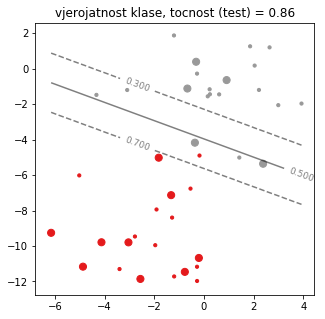

In [21]:
# Stvaramo dvije grupe od ukupno 40 tocaka
X, y = make_blobs(n_samples=40, centers=2, cluster_std=2.0, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = Pipeline([('logistic', LogisticRegression(solver='liblinear'))]) 
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Set1)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=plt.cm.Set1)

# Plotanje vjerojatnosti pripadnosti klasama
(XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
CS = ax.contour(XX, YY, Z, colors='k', levels=[0.3, 0.5, 0.7], alpha=0.5, linestyles=['--', '-', '--'])
ax.clabel(CS, fontsize=9, inline=1)
ax.set(title='vjerojatnost klase, tocnost (test) = ' + '{0:.2f}'.format(accuracy_test))

plt.show();

In [22]:
# Koeficijenti logisticke regresije
w_est = [model.named_steps['logistic'].coef_[0,0],model.named_steps['logistic'].coef_[0,1]]
c_est = model.named_steps['logistic'].intercept_[0]

print('Koeficijenti logisticke regresije: '+str(w_est))
print('Pristranost (bias): '+str(c_est))

Koeficijenti logisticke regresije: [0.26164689609382236, 0.508077113132593]
Pristranost (bias): 2.011076925847832


**Pitanje** Koja je interpretacija ovih koeficijenta logističke regresije?

Nacrtajmo gore navedenu funkciju gubitka i provjerimo gdje se na njoj nalazi naše rješenje.

In [23]:
# Stvaramo dvije grupe od ukupno 40 tocaka
X, y = make_blobs(n_samples=40, centers=2, cluster_std=2.0, random_state=2)

# Mijenjamo iz {0,1} u {-1,1}
y = 2*y-1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Funkcija gubitka (pretpostavlja da je y iz skupa {-1,1})
loss = lambda w: -np.sum( np.log( np.exp( -y_train*(np.dot(X_train,w) + c_est)) + 1 ))

# Racunamo svaku vrijednost funkcije gubitka
xx = np.linspace(-1.5, 1.5, 30)
yy = np.linspace(-1.5, 1.5, 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = np.apply_along_axis(loss,1,xy).reshape(XX.shape)

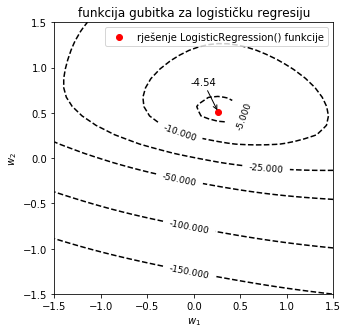

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Plotamo konture (koristite contourf() za popunjenu heatmapu)
CS = ax.contour(XX, YY, Z, colors='k', levels=[-150,-100,-50,-25,-10,-5], linestyles='--')
ax.clabel(CS, fontsize=9, inline=1)
ax.scatter(w_est[0],w_est[1],color='red',label='rješenje LogisticRegression() funkcije')
ax.annotate('{0:.2f}'.format(loss(w_est)),w_est,[w_est[0]-0.3,w_est[1]+0.3],arrowprops=dict(arrowstyle='->'))
ax.set(title='funkcija gubitka za logističku regresiju',
       xlabel='$w_1$',
       ylabel='$w_2$',
       xlim=(-1.5,1.5),
      ylim=(-1.5,1.5))
ax.legend()

plt.show();

**Pitanje** Što će se dogoditi s funkcijom gubitka ako promjenimo broj uzoraka na kojem učimo? Zašto?

Uspješnost kod klasifikacijskih problema možemo ocjeniti uz pomoć konfuzijske matrice (engl. confusion matrix) koja je implementirana u funkciji [`sklearn.metrics.confusion_matrix`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [25]:
print(confusion_matrix(y_test, model.predict(X_test)))

[[0 9 0]
 [0 0 0]
 [0 2 3]]


Malo ljepši ispis možemo dobiti uz pomoć Pandas funkcije [`pandas.crosstab`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html).

In [26]:
pd.crosstab(pd.Series(y_test,name='Stvarni'), 
            pd.Series(model.predict(X_test),name='Predikcija'),
            margins=True)

Predikcija,0,1,All
Stvarni,,,
-1,9,0,9
1,2,3,5
All,11,3,14


Nekoliko standardnih metrika za uspješnost klasifikacije možemo dobiti uz pomoć funkcije [`sklearn.metrics.classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [27]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         9
           0       0.00      0.00      0.00         0
           1       1.00      0.60      0.75         5

   micro avg       0.21      0.21      0.21        14
   macro avg       0.33      0.20      0.25        14
weighted avg       0.36      0.21      0.27        14



/home/matija/dev/env/science/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/matija/dev/env/science/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Prisjetimo se definicija preciznosti (engl. precision), osjetljivosti (engl. recall) i $F_1$ mjere:

$$
\text{preciznost} = \frac{TP}{TP + FP}
$$

$$
\text{osjetljivost} = \frac{TP}{TP + FN}
$$

$$
F_1 = 2 \frac{\text{preciznost} \times \text{osjetljivost}}{\text{preciznost} + \text{osjetljivost}}
$$

Pri čemu su TP broj stvarno pozitivnih primjera (engl. true positives), FP broj lažno pozitivnih primjera (engl. false positives) a FN broj lažno negativnih primjera (engl. false negatives). Za više detalja pogledajte poglavlje [3.3.2.8. Precision, recall and F-measures](http://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures) u scikit-learn korisničkoj dokumentaciji.

# 2.4. Korištenje polinomnih značajki u linearnoj i logističkoj regresiji

Termin *linearna* kod linearne regresije označava linearnost u parameterima, no to ne znači da ne možemo provesti linearnu regresiju na *nelinearnim* funckijama podataka. U općem slučaju možemo tražiti linearnu kombinaciju nekih baznih (i potencijalno nelinearnih) funkcija $f_i(x_i)$:

$$
\hat{y}(w,x) = \sum_{i=1}^p w_i f_i(x_i) + w_0
$$

Jednostavan primjer je korištenje polinomnih značajki, primjerice drugog stupnja, pri čemu se naš originalni problem s dvije značajke $\{x_1,x_2\}$:

$$
\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2
$$

Mijenja u:

$$
\hat{y}(w, x) = w_0 + w_1 x_1 + w_2 x_2 + w_3 x_1 x_2 + w_4 x_1^2 + w_5 x_2^2
$$

No i dalje je riječ o linearnom problemu jer su parametri regresije $\{w_0,w_1,w_2,w_4,w_5\}$ i dalje linearni, dok su originalni podaci prošireni s polinomnom reprezentacijom $\{x_1,x_2,x_1 x_2,x_1^2,x_2^2\}$. Za automatsko generiranje polinomnih značajki koristit ćemo funckiju [`sklearn.preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). Za više detalja pogledajte poglavlje [1.1.16. Polynomial regression: extending linear models with basis functions](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions) iz službene scikit-learn dokumentacije.

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split # u starijim verzijama sklearna nalazi se u modulu cross_validation
from sklearn.datasets import make_blobs

In [29]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [30]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X).astype(int)

array([[ 1,  0,  1,  0,  0,  1],
       [ 1,  2,  3,  4,  6,  9],
       [ 1,  4,  5, 16, 20, 25]])

In [31]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X).astype(int)

array([[ 1,  0,  1,  0],
       [ 1,  2,  3,  6],
       [ 1,  4,  5, 20]])

Korištenje polinomnih značajki kod polinoma trećeg stupnja - očekuje se točno rješenje.

In [32]:
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])

X = np.arange(5)[:, np.newaxis]
y = 3 - 2 * X + X ** 2 - X ** 3

model = model.fit(X, y)
model.named_steps['linear'].coef_

array([[ 3., -2.,  1., -1.]])

Korištenje samo interakcijskih značajki na XOR problemu.

In [33]:
model = Pipeline([('interact', PolynomialFeatures(interaction_only=True)),
                  ('linear', LinearRegression(fit_intercept=False))])

X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = X[:, 0] ^ X[:, 1]

model = model.fit(X, y)
model.predict(X).astype(int)

array([0, 1, 1, 0])

In [34]:
model.score(X, y)

1.0

Korištenje polinomnih atributa kod linearne regresije.

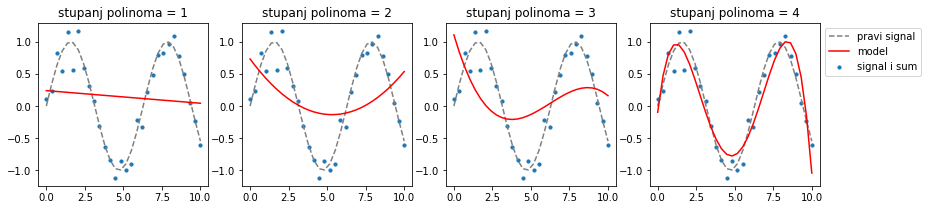

In [35]:
X = np.linspace(0.0,10.0,30)[:, np.newaxis]
y = np.sin(X) + np.random.normal(0.0,0.2,X.shape)

fig, ax = plt.subplots(1, 4, figsize=(14, 3))

for i,degree in enumerate([1,2,3,4]):
    model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                      ('linear', LinearRegression())])

    model = model.fit(X, y)

    ax[i].scatter(X[:, 0], y[:, 0], s=10, cmap=plt.cm.Set1, label='signal i sum')
    ax[i].plot(X[:, 0], np.sin(X), c='gray', linestyle='--', label='pravi signal');
    ax[i].plot(X,model.predict(X),'-r',label='model')
    ax[i].set(title='stupanj polinoma = ' + str(degree))
    if (i==3): ax[i].legend(loc='upper left', bbox_to_anchor=(1,1))

plt.show();

Polinomne atribute možemo koristiti i u logističkoj regresiji za klasifikacijske probleme.

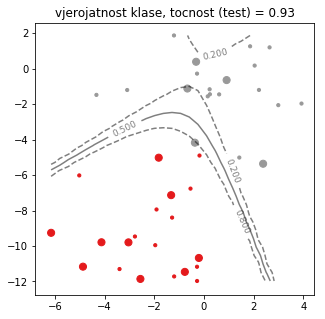

In [36]:
# we create 40 separable points
X, y = make_blobs(n_samples=40, centers=2, cluster_std=2.0, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('logistic', LogisticRegression(solver='liblinear'))])

model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Set1)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=plt.cm.Set1)

# Plotanje vjerojatnosti pripadnosti klasama
(XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
CS = ax.contour(XX, YY, Z, colors='k', levels=[0.2, 0.5, 0.8], alpha=0.5, linestyles=['--', '-', '--'])
ax.clabel(CS, fontsize=9, inline=1)
ax.set(title='vjerojatnost klase, tocnost (test) = ' + '{0:.2f}'.format(accuracy_test))

plt.show();

Točnost klasifikacije u ovisnosti o stupnju polinoma, odvojeno za skup za treniranje i za skup za testiranje (krivulja učenja).

/home/matija/dev/env/science/lib/python3.7/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


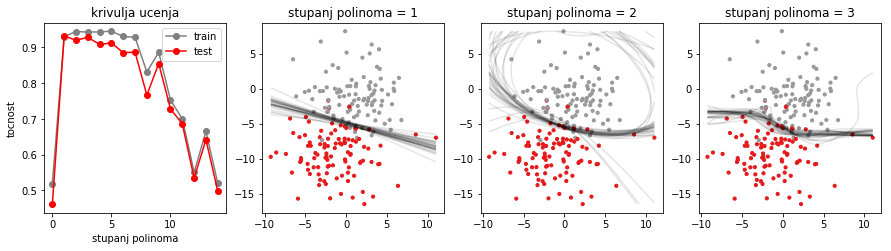

In [37]:
# we create 40 separable points
X, y = make_blobs(n_samples=200, centers=2, cluster_std=3.0, random_state=2)

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))

degrees = range(15)
accuracy_train = []
accuracy_test = []
    
for degree in degrees:
    
    if degree in [1,2,3]:
        ax[degree].scatter(X[:, 0], X[:, 1], c=y, s=10, cmap=plt.cm.Set1)
        ax[degree].set(title='stupanj polinoma = ' + str(degree))

    temp_train = 0.0
    temp_test = 0.0

    for temp in range(30):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33) # , random_state=42)

        model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                          ('logistic', LogisticRegression(solver='liblinear',max_iter=200))])

        model.fit(X_train, y_train)

        temp_train += model.score(X_train,y_train)
        temp_test += model.score(X_test,y_test)
        
        if degree in [1,2,3]:
            (XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
            CS = ax[degree].contour(XX, YY, Z, colors='k', levels=[0.5], alpha=0.1, linestyles=['-'])

    accuracy_train.append(temp_train/30.0)
    accuracy_test.append(temp_test/30.0)

ax[0].plot(degrees, accuracy_train, '-o', color='gray', label='train') 
ax[0].plot(degrees, accuracy_test, '-o', color='red', label='test') 
ax[0].legend(loc='upper right')
ax[0].set(title='krivulja ucenja',xlabel='stupanj polinoma',ylabel='tocnost')

plt.show();

**Pitanje 2.4.** Kako odabrati stupanj polinoma koji daje najbolje rezultate na još neviđenim podacima? Možemo li iskoristiti regularizaciju za to i ako da, kako?

**Vježba 2.3.** Regularizirajte gornji problem logističke regresije i usporedite rezultate. Napomena: Funkcija za logističku regresiju [`sklearn.linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) ima ugrađene opcije za regularizaciju - parametri `penalty` (vrsta regularizacije, `l1` ili `l2`) i `C` koji određuje jačinu regularizacije.

# 2.5. Naivni Bayes

Naivni Bayes je generativni model učenja koji koristi Bayesov teorem za procjenu vjerojatnosti pojedine klase. Osnovna pretpostavka algoritma je da su značajke nezavisne, što je rijetko zadovoljeno u praksi, ali bez obzira na to metoda obično daje dobre rezultate. Također, Naivni Bayes nema dodatnih parametara pa je odabir modela jednostavniji. Naivni Bayes modelira vjerojatnost da podaci $\{x_1,\dots,x_n\}$ pripadaju nekoj od klasa $y_k$ kao:

$$
P(y_k \mid x_1,\dots,x_n) = \frac{ P(y) \prod_{i=1}^{n} P(x_i \mid y) }{ \sum_{i} P(y_i) P(x_1,\dots,x_n \mid y_i) }
$$

Primjetite da je nazivnik zapravo $P(x_1,\dots,x_n)$ - apriorna vrijednost pojavljivanja podataka ${x_1,\dots,x_n}$ i prema tome je jednak za sve klase koje razmatramo. Ako želimo naći samo najvjerojatniju klasu možemo ga zanemariti pa kriterij odabira klase postaje:

$$
\hat {y}={\underset {k\in \{1,\dots ,K\}}{\operatorname {argmax} }}\ P(y_{k})\displaystyle \prod _{i=1}^{n}P(x_{i}\mid y_{k})
$$

Postoji nekoliko verzija Naivnog Bayesa ovisno o tome kakav oblik izglednosti (engl. likelihood) $P(x_i|y)$ odaberemo. Gaussov naivni Bayes radi klasifikaciju na numeričkim značajkama i modelira izglednost kao normalnu razdiobu s parametrima $(\mu_y,\sigma^2_y)$:

$$
P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)
$$

Parametri se estimiraju pomoću maksimalne izglednosti (engl. maximum likelihood): $\hat{\mu_y} = \frac{1}{N} \sum_{i=1}^{N} x_i$, $\hat{\sigma}_y^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i-\hat{\mu})^2$. Multinomialni naivni Bayes radi klasifikaciju u prostoru kategorijskih značajki i modelira izglednost kao multinomijalnu razdiobu s parametrima $\theta_y=(\theta_{y1},\dots,\theta_{yn})$:

$$
P(x_i \mid y) = \theta_{y}^{x_i}
$$

Parametri se estimiraju pomoću izglađene maksimalne izglednosti:

$$
\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}
$$

Gdje je $N_{yi} = \sum_{x \in T} x_i$ broj koliko puta se značajka $i$ pojavljuje u podacima za učenje $T$ klase $y$, a $N_{y} = \sum_{i=1}^{|T|} N_{yi}$ je ukupni broj svih svih značajki za klasu $y$. Parametar izglađivanja $\alpha \geq 0$ pridodaje minimalnu vjerojatnost čak i značajkama koje nisu zastupljene u skupu za učenje. U slučaju $\alpha = 1$ imamo Laplaceovo izglađivanje (engl. Laplace smoothing).

Koristit ćemo verziju Gaussovog naivnog Bayesa implementiranu u funkciji [`sklearn.naive_bayes.GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) za klasifikaciju u prostoru numeričkih značajki. Multinomialni naivni Bayes je implementiran u funkciji [`sklearn.naive_bayes.MultinomialNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB). Za više detalja pogledajte poglavlje [1.9. Naive Bayes](http://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) u scikit-learn korisničkoj dokumentaciji.

In [38]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

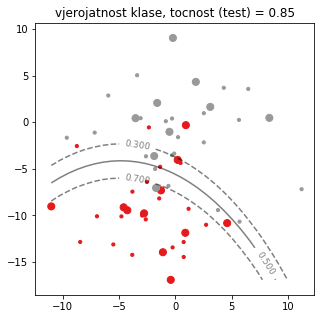

In [39]:
X, y = make_blobs(n_samples=60, centers=2, cluster_std=4.0, random_state=2)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test) # Tocnost je default mjera za LogisticRegression()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Set1)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=plt.cm.Set1)
    
(XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
CS = ax.contour(XX, YY, Z, colors='k', levels=[0.3,0.5,0.7], alpha=0.5, linestyles=['--','-','--'])
ax.clabel(CS, fontsize=9, inline=1)
ax.set(title='vjerojatnost klase, tocnost (test) = ' + '{0:.2f}'.format(accuracy_test))

plt.show();

# 2.6. Stroj s potpornim vektorima (SVM)

Stroj s potpornim vektorima (engl. support vector machine, SVM) rješava sljedeći optimizacijski problem:

$$
\min_ {w, b, \zeta} \frac{1}{2} w^T w + C \sum_{i=1}^{n} \zeta_i,  \quad y_i (w^T \phi (x_i) + b) \geq 1 - \zeta_i, \quad \zeta_i \geq 0, i=1, ..., n
$$

Gdje su $\{x_1,\dots,x_n\}$ primjeri za treniranje a $y \in \{-1,1\}$ ciljna značajka. Zbog efikasnosti često se zapravo rješava dualni problem:

$$
\min_{\alpha} \frac{1}{2} \alpha^T Q \alpha - e^T \alpha, \quad y^T \alpha = 0, \quad 0 \leq \alpha_i \leq C, i=1, ..., n
$$

Koristit ćemo SVM implementiran u funkciji [`sklearn.svm.SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) koji interno koristi [libsvm](https://www.csie.ntu.edu.tw/~cjlin/libsvm/).

Umjesto funkcije [`sklearn.svm.SVC.predict_proba()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba) koja vraća vjerojatnosti za svaku klasu (od 0 do 1), za SVM ćemo koristiti [`sklearn.svm.SVC.decision_function()`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.decision_function) koja vraća udaljenost od decizijske hiperravnine. Potporni vektori su oni primjeri koji leže na udaljenost 1 od hiperravnine!

Za sličan primjer u scikit-learn dokumentaciji pogledajte [SVM: Maximum margin separating hyperplane](http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html#sphx-glr-auto-examples-svm-plot-separating-hyperplane-py).

In [40]:
from sklearn import svm
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

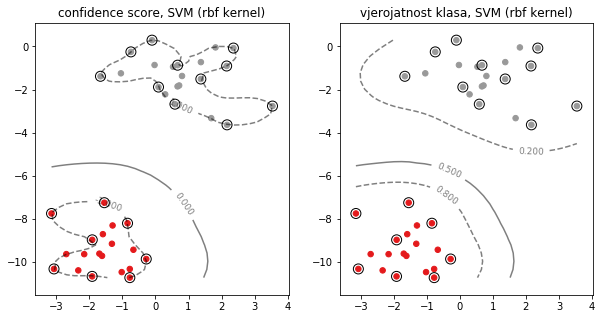

In [41]:
# we create 40 separable points
X, y = make_blobs(n_samples=60, centers=2, cluster_std=1.0, random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# fit the model, don't regularize for illustration purposes
kernel = 'rbf' # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
model = Pipeline([('SVM', svm.SVC(kernel=kernel, probability=True, gamma='auto'))]) 
model.fit(X_train, y_train)
accuracy_test = model.score(X_test,y_test)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    ax[i].scatter(X_train[:,0], X_train[:,1], c=y_train, s=30, cmap=plt.cm.Set1)
    # Plotanje potpornih vektora
    ax[i].scatter(model.named_steps['SVM'].support_vectors_[:,0], model.named_steps['SVM'].support_vectors_[:,1], 
                  s=100, linewidths=1, edgecolors='black', facecolors='none')

# Plotanje decizijske funkcije i confidence scorea
(XX,YY,Z) = calculate_decision_function(X_train, model.decision_function)
CS = ax[0].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
ax[0].clabel(CS, fontsize=9, inline=1)
ax[0].set(title='confidence score, SVM (' + kernel + ' kernel)')
    
# Plotanje vjerojatnosti pripadnosti klasama
(XX,YY,Z) = calculate_decision_function(X_train, lambda x: model.predict_proba(x)[:,0])
CS = ax[1].contour(XX, YY, Z, colors='k', levels=[0.2, 0.5, 0.8], alpha=0.5, linestyles=['--', '-', '--'])
ax[1].clabel(CS, fontsize=9, inline=1)
ax[1].set(title='vjerojatnost klasa, SVM (' + kernel + ' kernel)')

plt.show();

Utjecaj parametara $C$ i $\gamma$.

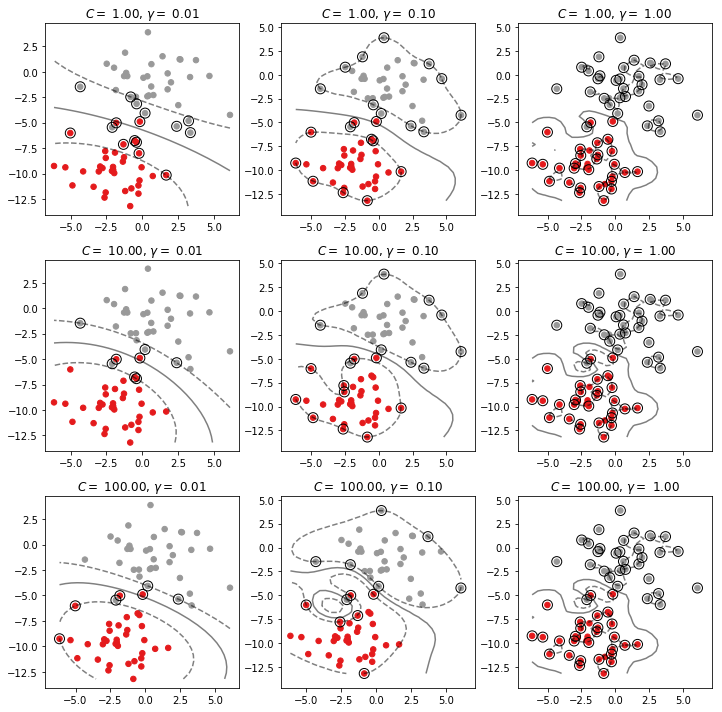

In [42]:
X, y = make_blobs(n_samples=70, centers=2, cluster_std=2.0, random_state=2)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i,C in enumerate([1.0,10.0,100.0]):
    for j,gamma in enumerate([0.01,0.1,1.0]):
          
        model = Pipeline([('SVM', svm.SVC(kernel='rbf', C=C, gamma=gamma))]) 
        model.fit(X, y)

        ax[i][j].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Set1)

        # Plotanje decizijske funkcije i confidence scorea
        (XX,YY,Z) = calculate_decision_function(X, model.decision_function)
        CS = ax[i][j].contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

        # Plotanje potpornih vektora
        ax[i][j].scatter(model.named_steps['SVM'].support_vectors_[:, 0], model.named_steps['SVM'].support_vectors_[:, 1], 
                         s=100, linewidths=1, edgecolors='black', facecolors='none')
        ax[i][j].set(title='$C=$ '+'{0:.2f}'.format(C)+', $\gamma =$ '+'{0:.2f}'.format(gamma))


fig.tight_layout();

**Primjer na stvarnim podacima:** Klasifikacija teksta.

In [43]:
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV # In new version (0.19. it's in model_selection module!)
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
]

print("Ucitavanje '20 newsgroups' skupa podataka za sljedece kategorije:")
print(categories)

data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=1,
                          remove=('headers', 'footers', 'quotes'),
                          data_home='../assets/datasets/zip',
                          download_if_missing=False) # Podaci su dostupni lokalno

data_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=1,
                          remove=('headers', 'footers', 'quotes'),
                          data_home='../assets/datasets/zip',
                          download_if_missing=False) # Podaci su dostupni lokalno

print("Ucitano %d dokumenata za treniranje" % len(data.filenames))
print("Ucitano %d dokumenata za testiranje" % len(data_test.filenames))

Ucitavanje '20 newsgroups' skupa podataka za sljedece kategorije:
['alt.atheism', 'talk.religion.misc']
Ucitano 857 dokumenata za treniranje
Ucitano 570 dokumenata za testiranje


In [45]:
[t.upper()+' => '+s[:300]+'[...]' for s,t in zip(data.data[:5],np.take(data.target_names,data.target[:5]))]

['ALT.ATHEISM => Deletions...\n\nSo, you consider the german poster\'s remark anti-semitic?  Perhaps you\nimply that anyone in Germany who doesn\'t agree with israely policy in a\nnazi?  Pray tell, how does it even qualify as "casual anti-semitism"? \nIf the term doesn\'t apply, why then bring it up?\n\nYour own bigotry is sh[...]',
 'ALT.ATHEISM => \n  If the Anne Frank exhibit makes it to your small little world,\n  take an afternoon to go see it.  \n\n\n/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\/\\ \n\nBob Beauchaine bobbe@vice.ICO.TEK.COM \n\nThey said that Queens could stay, they blew the Bronx away,\nand sank Manhattan out at[...]',
 'TALK.RELIGION.MISC => \n\n(Pleading mode on)\n\nPlease!  I\'m begging you!  Quit confusing religious groups, and stop\nmaking generalizations!  I\'m a Protestant!  I\'m an evangelical!  I don\'t\nbelieve that my way is the only way!  I\'m not a "creation scientist"!  I\ndon\'t think that homos

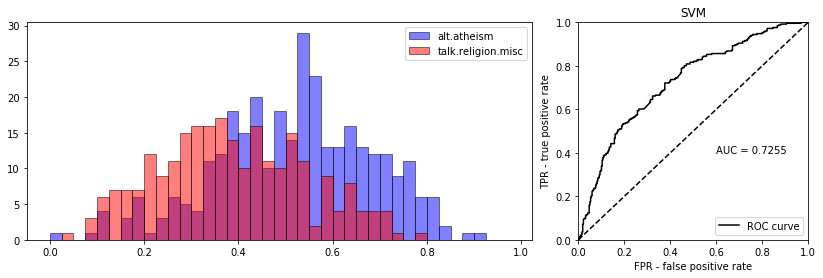

In [46]:
# Klasifikacija bez pretrazivanja parametara
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('SVM', svm.SVC(kernel='rbf',probability=True, gamma='auto'))
])

model = pipeline.fit(data.data, data.target)
y_pred = model.predict_proba(data_test.data)

fpr, tpr, thresholds = roc_curve(data_test.target,y_pred[:,1])
auc_score = roc_auc_score(data_test.target,y_pred[:,1])

fig = plt.figure(figsize=(14, 4))

ax0 = plt.subplot2grid((1,3), (0,0), colspan=2)
ax0.hist(y_pred[data_test.target==0,0], bins=np.arange(0.0,1.0,0.025), 
         color='b', edgecolor='k', alpha=.5, label='alt.atheism')
ax0.hist(y_pred[data_test.target==1,0], bins=np.arange(0.0,1.0,0.025), 
         color='r', edgecolor='k', alpha=.5, label='talk.religion.misc')
ax0.legend(loc='upper right')

ax1 = plt.subplot2grid((1,3), (0,2))
ax1.plot(fpr,tpr,color='black',label='ROC curve')
ax1.plot([0,1],[0,1],color='black',linestyle='dashed')
ax1.set(xlabel='FPR - false positive rate',ylabel='TPR - true positive rate',title='SVM',
        xlim=(0,1),ylim=(0,1))
ax1.text(0.6,0.4,'AUC = ' + '{0:.4f}'.format(auc_score))
ax1.legend(loc='lower right')

plt.show();

Defaultna metoda evaluacije za [`GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html#sklearn.grid_search.GridSearchCV) je defaultna metoda od predikcijskog algoritma, a ovdje je to točnost jer je prediktivni algoritam [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). No ovdje smo odabrali AUC, za ostale mogućnosti pogledajte scikit-learn dokumentaciju za [evaluaciju modela](http://scikit-learn.org/0.17/modules/classes.html#module-sklearn.grid_search).

In [47]:
# Klasifikacija s pretrazivanjem parametara C i gamma za SVM
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('SVM', svm.SVC(kernel='rbf',probability=True))
])

parameters = {
    'SVM__C':(1.0,10.0,100.0,1000.0),
    'SVM__gamma':(0.001,0.01,0.1,1.0)
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected block
    grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=1, scoring='roc_auc')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_) 
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'SVM']
parameters:
{'SVM__C': (1.0, 10.0, 100.0, 1000.0), 'SVM__gamma': (0.001, 0.01, 0.1, 1.0)}
Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.5min finished


done in 92.448s

Best score: 0.858
Best parameters set:
	SVM__C: 10.0
	SVM__gamma: 0.1


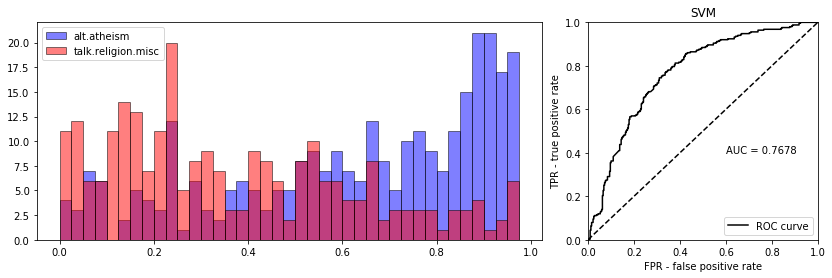

In [48]:
model = grid_search.best_estimator_.fit(data.data, data.target)
y_pred = model.predict_proba(data_test.data)

fpr, tpr, thresholds = roc_curve(data_test.target,y_pred[:,1])
auc_score = roc_auc_score(data_test.target,y_pred[:,1])

fig = plt.figure(figsize=(14, 4))

ax0 = plt.subplot2grid((1,3), (0,0), colspan=2)
ax0.hist(y_pred[data_test.target==0,0], bins=np.arange(0.0,1.0,0.025), color='b', edgecolor='k', alpha=.5, label='alt.atheism')
ax0.hist(y_pred[data_test.target==1,0], bins=np.arange(0.0,1.0,0.025), color='r', edgecolor='k', alpha=.5, label='talk.religion.misc')
ax0.legend(loc='upper left')

ax1 = plt.subplot2grid((1,3), (0,2))
ax1.plot(fpr,tpr,color='black',label='ROC curve')
ax1.plot([0,1],[0,1],color='black',linestyle='dashed')
ax1.set(xlabel='FPR - false positive rate',ylabel='TPR - true positive rate',title='SVM',xlim=(0,1),ylim=(0,1))
ax1.text(0.6,0.4,'AUC = ' + '{0:.4f}'.format(auc_score))
ax1.legend(loc='lower right')

plt.show();

U slučaju da kao output ne tražimo vjerojatnosne vrijednosti nego diskretne klase, za evaluaciju možemo korisiti i funkciju [`classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [49]:
# Klasifikacija bez pretrazivanja parametara
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('SVM', svm.SVC(kernel='rbf', gamma='auto'))
])

model = pipeline.fit(data.data, data.target)
y_pred = model.predict(data_test.data)

print('Bez pretrazivanja parametara...')
print(classification_report(data_test.target, y_pred))

# Klasifikacija s pretrazivanjem parametara
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('SVM', svm.SVC(kernel='rbf',C=10.0,gamma=0.1)) # Odabiremo najbolje parametre iz GridSearchCV
])

model = pipeline.fit(data.data, data.target)
y_pred = model.predict(data_test.data)

print('S pretrazivanjem parametara...')
print (classification_report(data_test.target, y_pred))

Bez pretrazivanja parametara...
              precision    recall  f1-score   support

           0       0.56      1.00      0.72       319
           1       0.00      0.00      0.00       251

   micro avg       0.56      0.56      0.56       570
   macro avg       0.28      0.50      0.36       570
weighted avg       0.31      0.56      0.40       570



/home/matija/dev/env/science/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


S pretrazivanjem parametara...
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       319
           1       0.67      0.68      0.67       251

   micro avg       0.71      0.71      0.71       570
   macro avg       0.71      0.71      0.71       570
weighted avg       0.71      0.71      0.71       570



Osim optimizacije metaparametara, za uspješno korištenje SVM-a korisno je slijediti još nekoliko praktičnih savjeta. Za više detalja pogledajte poglavlje [Tips on practical use](http://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use) u scikit-learn korisničkoj dokumentaciji.

**Vježba 2.4.** Promjenite gornji primjer s pretraživanjem parametera tako da se pretražuju i parametri funkcija za pretprocesiranje značajki: `sklearn.feature_extraction.text.CountVectorizer` i `sklearn.feature_extraction.text.TfidfTransformer`. Prijedlog parametara i njihovih raspona:

```python
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
}
```

# 2.7. Slučajne šume

U ovoj vježbi koristit ćemo algoritam slučajnih šuma (engl. random forest) implementiran u funkciji [`sklearn.ensemble.RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Random forest generira ansambl stabla odlučivanja (engl. decision trees) i uprosječuje njihova predviđanja. Svako stablo je izgrađeno na slučajnom podskupu (s ponavljanjem) skupa za učenje i prilikom izgradnje svakog stabla se uvijek uzima slučajni podskup značajki za izgradnju svakog pojedinog čvora. Paranetar `n_estimators` regulira broj stabala dok parametar `max_features` regulira broj nasumično odabranih značajki koje se razmatraju prilikom izgradnje svakog čvora. Parametar `max_depth` regulira maksimalnu dubinu stabala u ansamblu. Svako stablo se gradi nezavisno pa je algoritam moguće lako paralelizirati - parametar `n_jobs` regulira koliko procesorskih jezgri će se koristiti prilikom učenja (vrijednost `-1` označava korištenje svih jezgri). Za više detalja pogledajte poglavlje [1.11.2. Forests of randomized trees](http://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees) u scikit-learn korisničkoj dokumentaciji.

In [50]:
from sklearn.datasets import make_blobs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

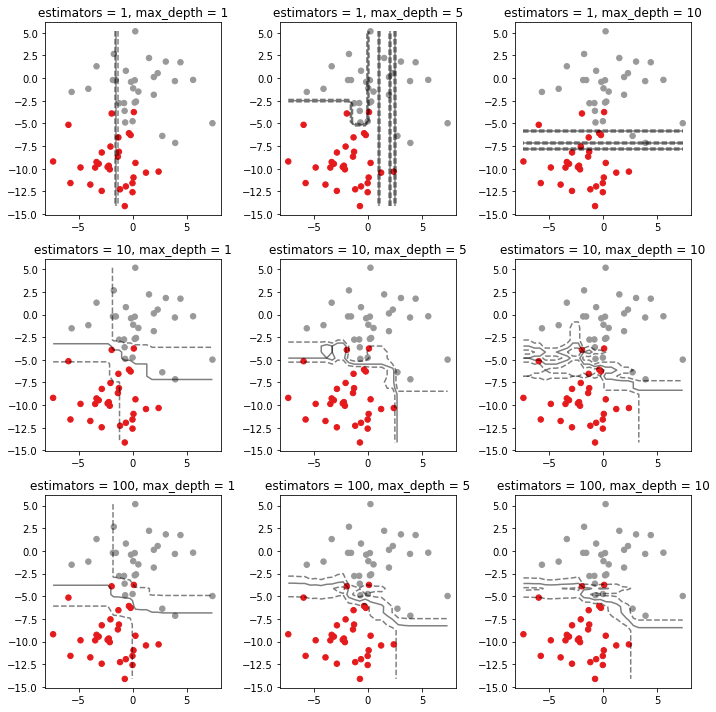

In [51]:
X, y = make_blobs(n_samples=60, centers=2, cluster_std=2.5, random_state=2)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i,n_estimators in enumerate([1,10,100]):
    for j,max_depth in enumerate([1,5,10]):
          
        model = Pipeline([('RF', RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth))]) 
        model.fit(X, y)

        ax[i][j].scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Set1)

        # Plotanje vjerojatnosti pripadnosti klasama
        (XX,YY,Z) = calculate_decision_function(X, lambda x: model.predict_proba(x)[:,0])
        CS = ax[i][j].contour(XX, YY, Z, colors='k', levels=[0.3, 0.5, 0.7], alpha=0.5, linestyles=['--', '-', '--'])

        ax[i][j].set(title='estimators = ' + str(n_estimators) + ', max_depth = ' + str(max_depth))

fig.tight_layout();